In [88]:
# Import Required Libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import sys
sys.path.append('./src')
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report


# Model Evaluation on PlantVillage Dataset

This notebook evaluates the trained model using the test set. It includes metrics, confusion matrix, ROC curves, and a classification report.

In [89]:
from src.config_par import IMG_SIZE, BATCH_SIZE


In [90]:
# Seed setting for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)


In [91]:
import tensorflow_datasets as tfds
from preprocessing import preprocess

# Load Trained Model and Test Data
arch_choice = 1  # Choose the architecture version
if arch_choice not in [0, 1, 2, 3, 4]:
    raise ValueError("Invalid architecture choice")

model = keras.models.load_model(f'./weights/best_model_v{arch_choice}.h5')

ds_info = tfds.builder('plant_village').info
ds_test = tfds.load('plant_village', split='train[95%:]', as_supervised=True)

test_ds = ds_test.map(lambda image, label: preprocess(image, label, ds_info, IMG_SIZE)).batch(BATCH_SIZE[arch_choice]).prefetch(tf.data.AUTOTUNE)
class_names = ds_info.features['label'].names


In [92]:
# Generate Predictions on Test Set
y_true = []
y_pred = []
y_score = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_score.append(preds)
y_score = np.concatenate(y_score)


1/1 [==============================] - 0s 36ms/step


In [93]:
# Calculate Evaluation Metrics (Accuracy, Precision, Recall, F1)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1-score: {f1:.6f}")


Accuracy: 0.874033
Precision: 0.887482
Recall: 0.874033
F1-score: 0.873160


/Users/2mc/miniconda3/envs/daml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

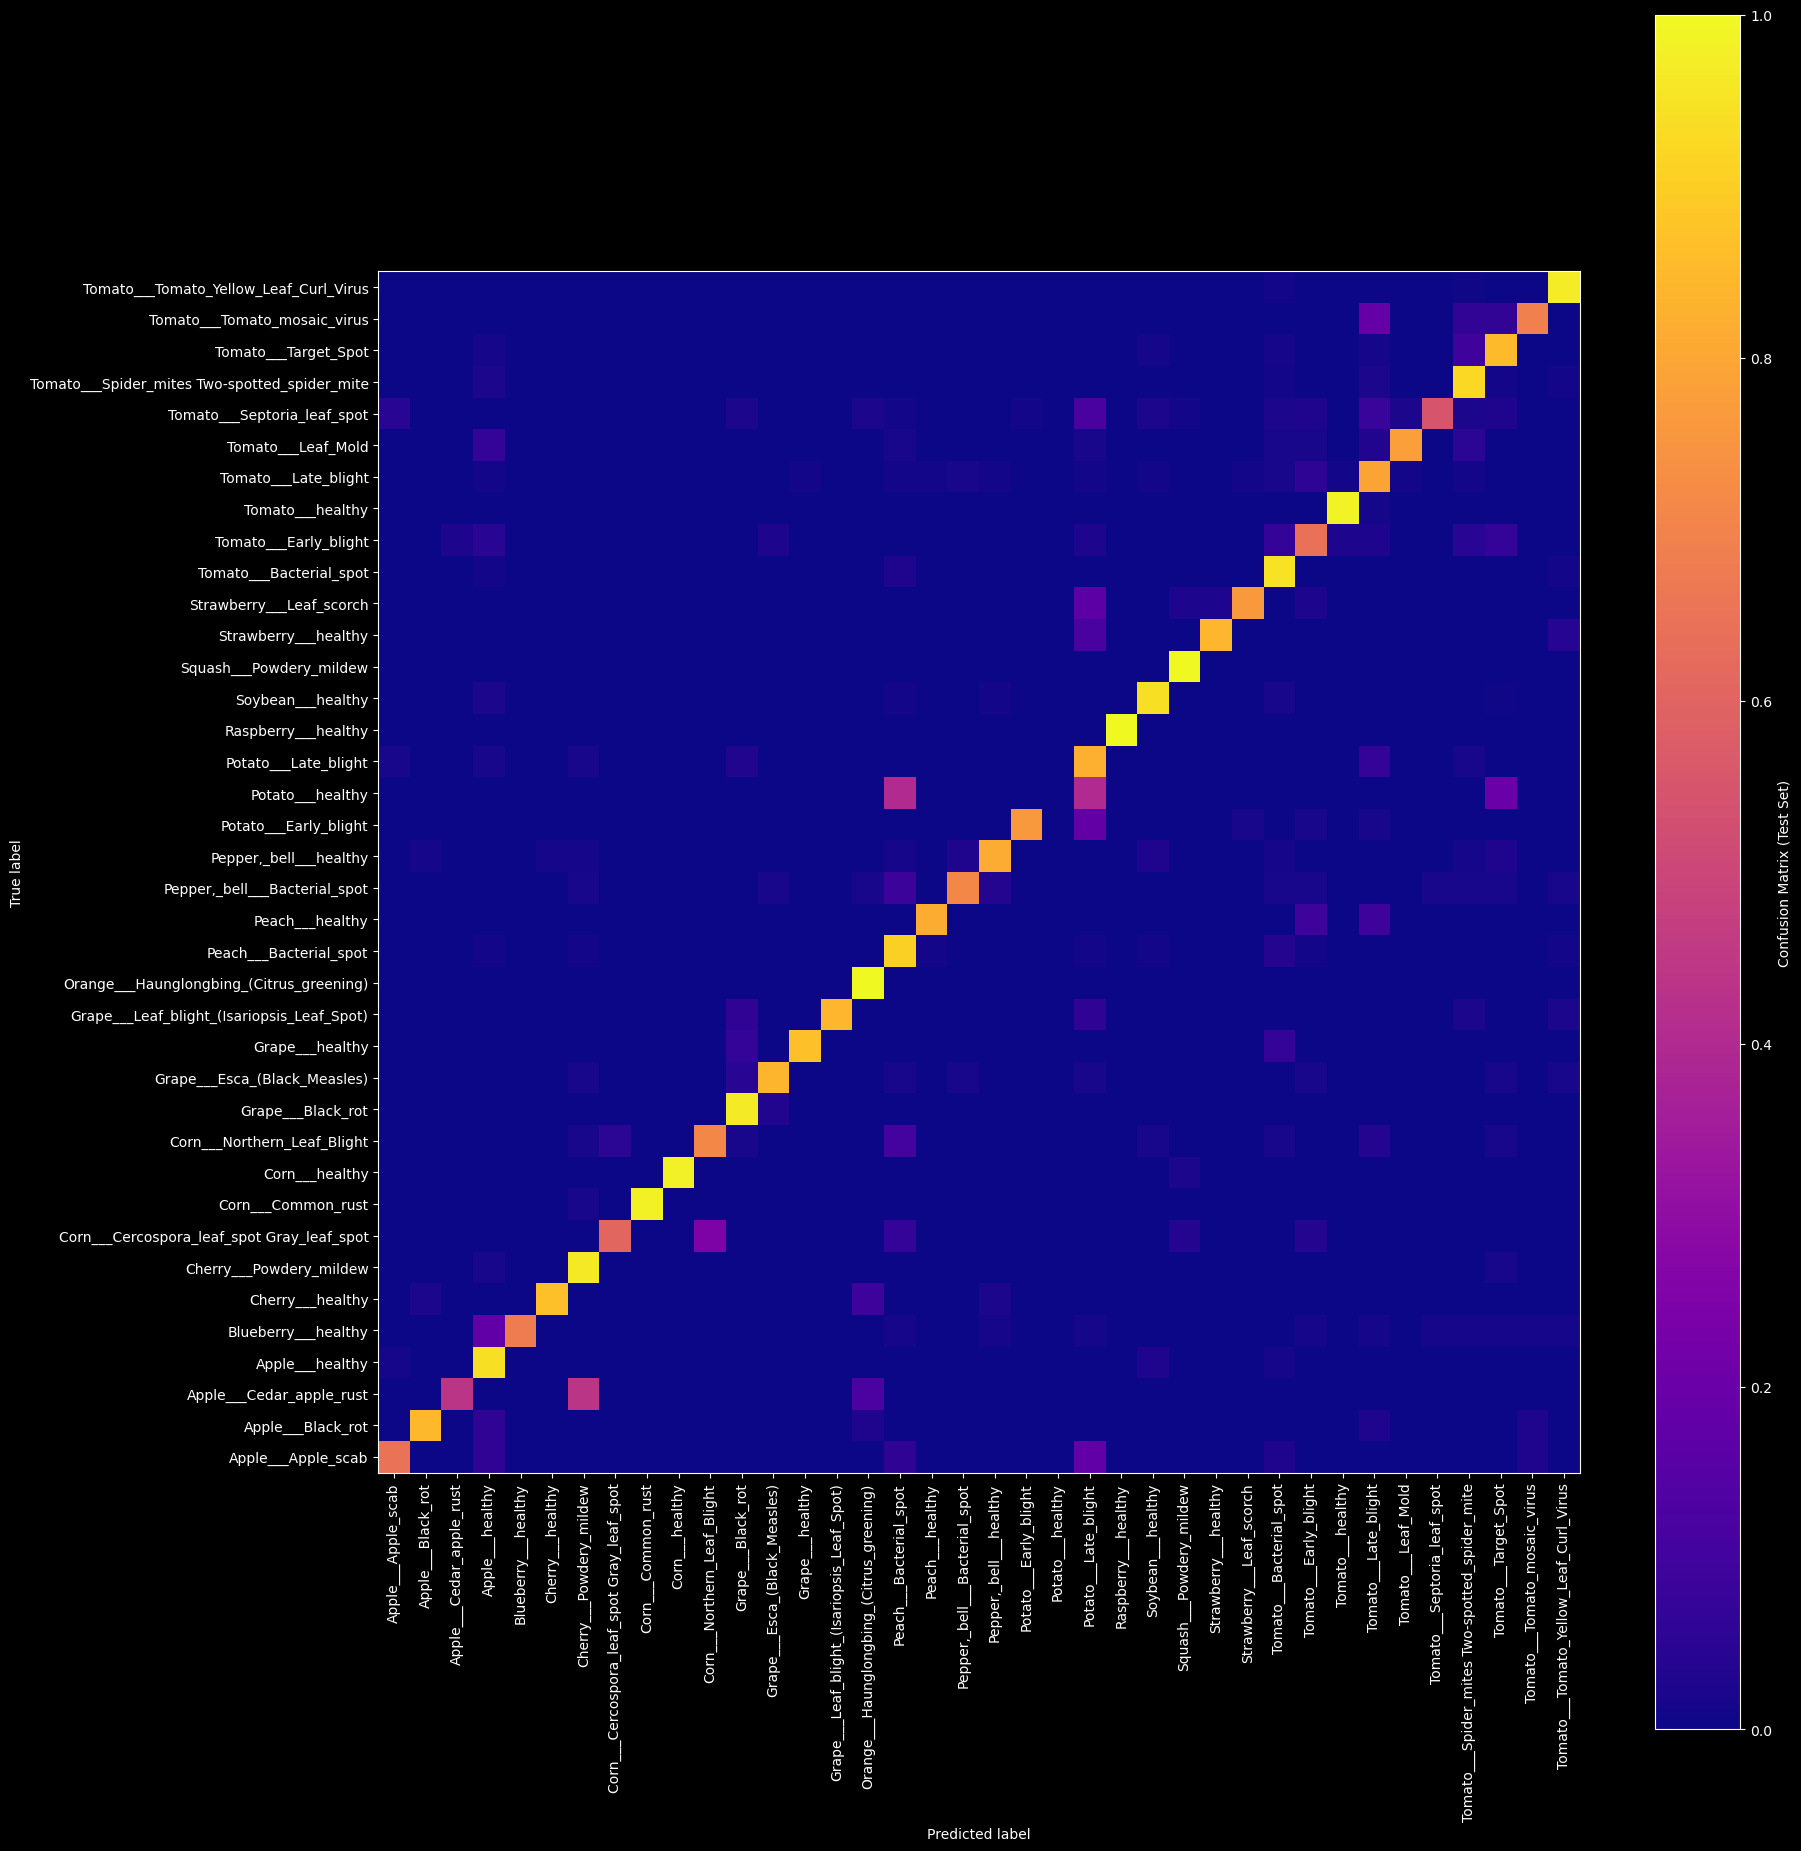

In [94]:
import matplotlib.pyplot as plt
from plotting import plot_confusion_matrix

plt.figure()  # Set a larger figure size for better readability
plot_confusion_matrix(
    np.array(y_true),
    np.array(y_pred),
    classes=class_names,
    normalize=True,
    title="Confusion Matrix (Test Set)",
    cmap="plasma"
)
plt.tight_layout()  # Ensure labels and ticks are not cut off
plt.savefig(f'./conf-matrix/confusion_matrix_v{arch_choice}.png', dpi=400, bbox_inches='tight')
plt.show()


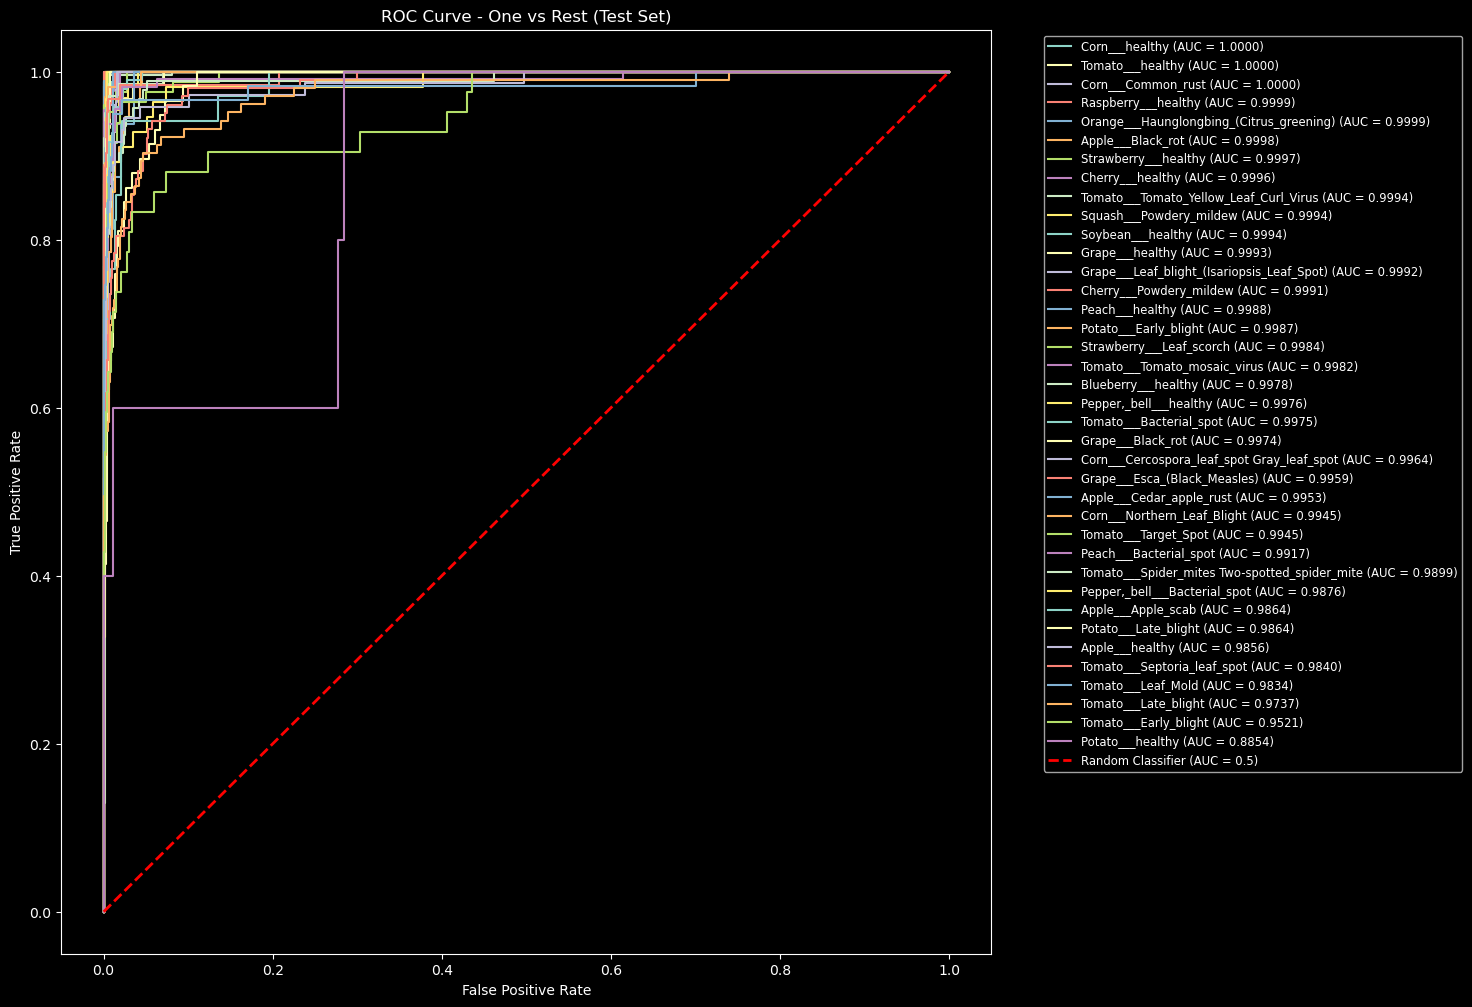

In [95]:
# Plot ROC Curves for Each Class
n_classes = y_score.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.eye(n_classes)[y_true][:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(np.eye(n_classes)[y_true][:, i], y_score[:, i])
plt.figure(figsize=(12, 12))
auc_and_idx = sorted([(roc_auc[i], i) for i in range(n_classes)], reverse=True)
for auc, i in auc_and_idx:
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs Rest (Test Set)')
plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='best')
plt.savefig(f'./roc-curves/roc_curve_v{arch_choice}.png', dpi=400, bbox_inches='tight')
plt.show()


In [96]:
# Display Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# Save the classification report to a text file
with open(f'./reports/report_v{arch_choice}.txt', 'w') as f:
    f.write(report)


                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.76      0.65      0.70        34
                            Apple___Black_rot       0.93      0.85      0.89        33
                     Apple___Cedar_apple_rust       0.88      0.44      0.58        16
                              Apple___healthy       0.65      0.94      0.77        72
                          Blueberry___healthy       1.00      0.68      0.81        68
                             Cherry___healthy       0.97      0.86      0.92        44
                      Cherry___Powdery_mildew       0.79      0.96      0.87        54
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.85      0.61      0.71        28
                           Corn___Common_rust       1.00      0.98      0.99        60
                               Corn___healthy       1.00      0.98      0.99        49
                  Corn___Northern_Leaf_Bli

/Users/2mc/miniconda3/envs/daml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/2mc/miniconda3/envs/daml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/2mc/miniconda3/envs/daml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
